# Starter code

In [12]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

def display_img(img, title="Store Map", figsize=(15, 10), cmap='gray', minmax=True):
    plt.figure(figsize=figsize)
    if minmax:
        plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

def perlin(x, y, seed=0):
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    xi = x.astype(int)
    yi = y.astype(int)
    xf = x - xi
    yf = y - yi
    u = fade(xf)
    v = fade(yf)
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)
    return lerp(x1, x2, v)

def lerp(a, b, x):
    return a + x * (b - a)

def fade(t):
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y

def generate_noise_image(width, height, origin=0, scale_factor=5, seed=2):
    size = max([width, height])
    scale_x = width / size
    scale_y = height / size
    X = np.linspace(origin, scale_factor * scale_x, width, endpoint=False)
    Y = np.linspace(origin, scale_factor * scale_y, height, endpoint=False)
    x, y = np.meshgrid(X, Y)
    noise_img = perlin(x, y, seed=seed)
    return noise_img

In [15]:
def get_traffic_map_and_targets(N, traffic_seed, target_seed, origin=0, scale_factor=5):
    # Load store map
    im_gray = cv2.imread('1150.png', cv2.IMREAD_GRAYSCALE)
    # Binarize
    thresh, im_bw = cv2.threshold(im_gray, 254, 255, cv2.THRESH_BINARY_INV)
    # Fill holes to make impassable areas
    collision_map = im_bw.copy()
    contour, hier = cv2.findContours(collision_map, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        cv2.drawContours(collision_map, [cnt], 0, 255, -1)
    # Edge detect to generate valid targets
    valid_targets = cv2.Laplacian(collision_map, cv2.CV_64F)
    # Generate random targets
    random.seed(target_seed)
    im_targets = im_gray.copy()
    ys, xs = valid_targets.nonzero()
    target_indicies = random.sample(range(len(xs)), N)
    target_xs, target_ys = xs[target_indicies], ys[target_indicies]
    # Generate noise image for traffic
    width, height = len(im_targets[0]), len(im_targets)
    noise_img = generate_noise_image(width, height, seed=traffic_seed, origin=origin, scale_factor=scale_factor)
    noise_img = (noise_img - np.min(noise_img)) / (np.max(noise_img) - np.min(noise_img))
    # Merge noise and collisions
    travel_friction = (~collision_map>0).astype(int) * noise_img
    # Enforce collision map infinite condition
    travel_friction[collision_map>0] = np.inf
    # Make targets passable
    for x, y in zip(target_xs, target_ys):
        travel_friction[y][x] = 0
    # Return the friction map and the target points
    return travel_friction, list(zip(target_xs, target_ys))

In [19]:
map_img, target_points = get_traffic_map_and_targets(50, 42, 42, scale_factor=5)
disp_img = map_img.copy()
for x, y in zip(target_xs, target_ys):
    cv2.circle(disp_img, (x, y), circle_draw_size, (0, 0, 0), -1)
display_img(disp_img*255)

NameError: name 'target_xs' is not defined

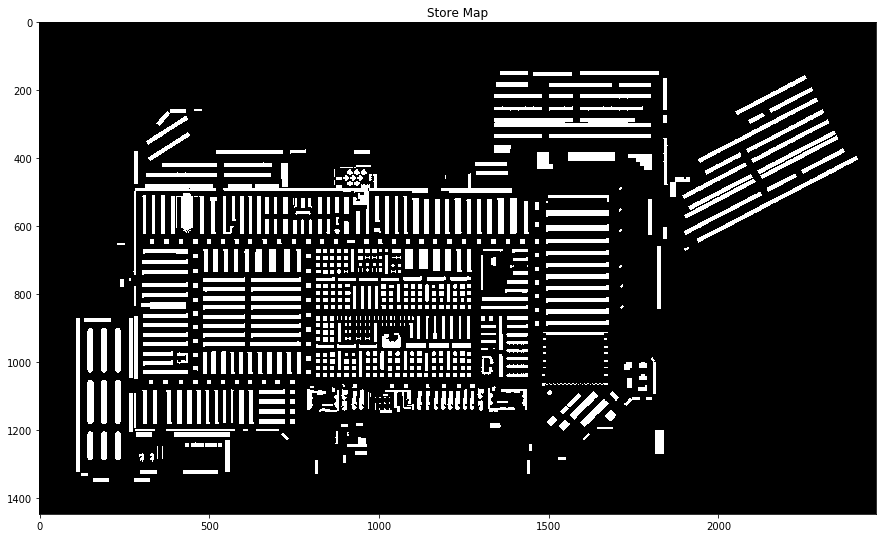

In [18]:
N = 50
traffic_seed = 42
target_seed = 42
map_image, target_coords = get_traffic_map_and_targets(N, traffic_seed, target_seed)
display_img(map_image)

# Algorithm description

1) Given a point of interest, $i$, filter out a subset of points $J$ around point $i$ 

2) Run a shortest path algorithm between $i$ and $j \in J$, filling in the $(i, j)$ entry of the distance matrix $D$.

3) Fill in all $(i, k != j)$ in $D$ to be  $\infty$.

4) Plug this complete distance matrix $D$ into an approximate solution for TSP. 

# Filtering 

In [ ]:
#imports


# Shortest path finding 

In [1]:
#imports 
from scipy.sparse.csgraph import dijkstra